# Display additional stats about the annotated images being used for training

This is not part of the core method. It just provides some additional information about the number and spatial size of the annotations for the various classes that were annotated. This sort of information can be useful for thinking about why certain classes may be detected better or worse than expected compared to other classes in the data set.

In [1]:
import os
import json
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import yaml

import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
import detectron2.utils.comm as comm
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

from detectron2.data import build_detection_train_loader
from detectron2.data import build_detection_test_loader

ungulates_root = os.path.dirname(os.path.dirname(os.getcwd()))
local_paths_file = os.path.join(ungulates_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(local_paths['overhead_functions_path'])
from print_instances_class_histogram import print_instances_class_histogram

sys.path.append(
    os.path.join(local_paths['overhead_functions_path'],
                 "detectron2_classes"
                )
)
from DetectionDatasetMapper import DetectionDatasetMapper
from DetectionTrainer import DetectionTrainer

In [2]:
# Local folder with annotated images and subfolder containing train.json
# and val.json files
annotations_folder = local_paths['annotations_folder'] 
# This the name of the subfolder that contains that annotation .jsons
annotation_set_name = "annotations-clean-name-pruned"

In [1]:
train_json = os.path.join(annotations_folder, annotation_set_name, 'train.json') 
val_json = os.path.join(annotations_folder, annotation_set_name, 'val.json')

register_coco_instances("train", {}, train_json, annotations_folder)
register_coco_instances("val", {}, val_json, annotations_folder)

In [5]:
train_metadata = MetadataCatalog.get("train")
train_dicts = DatasetCatalog.get("train")
val_dicts = DatasetCatalog.get("val")

### Info about number of classes, images, and instances annnotated

In [6]:
num_train_images = len(train_dicts)
num_val_images = len(val_dicts)
print(f"{num_train_images} training images \n"
      + f"{num_val_images} validation images")

train_metadata = MetadataCatalog.get("train")
print(f"Annotated classes: {train_metadata.get('thing_classes')}")

1340 training images 
286 validation images
Annotated classes: ['zebra', 'gazelle', 'wbuck', 'buffalo', 'other']


In [7]:
print("\nTrain frames:")
print_instances_class_histogram(train_dicts, train_metadata.get("thing_classes"), num_frames=True)
print("\nTrain annotations:")
print_instances_class_histogram(train_dicts, train_metadata.get("thing_classes"), num_frames=False)
print("\nValidation frames:")
print_instances_class_histogram(val_dicts, train_metadata.get("thing_classes"), num_frames=True)
print("\nValidation annotations:")
print_instances_class_histogram(val_dicts, train_metadata.get("thing_classes"), num_frames=False)


Train frames:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   zebra    | 1007         |  gazelle   | 378          |   wbuck    | 63           |
|  buffalo   | 192          |   other    | 172          |            |              |
|   total    | 1812         |            |              |            |              |

Train annotations:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   zebra    | 14315        |  gazelle   | 4830         |   wbuck    | 498          |
|  buffalo   | 6192         |   other    | 854          |            |              |
|   total    | 26689        |            |              |            |              |

Validation frames:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |

### Info about the actual size of bounding boxes for the various classes

In [21]:
import logging
import itertools

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

zebra: mean: 3660.0444289207126 lowwer_quartile: 2626.0 upper_quartile: 4218.0 num annotations: 14315
gazelle: mean: 1604.1403726708074 lowwer_quartile: 1089.0 upper_quartile: 1920.0 num annotations: 4830
wbuck: mean: 2888.5803212851406 lowwer_quartile: 2472.5 upper_quartile: 3256.0 num annotations: 498
buffalo: mean: 5650.740956072352 lowwer_quartile: 3690.0 upper_quartile: 7392.0 num annotations: 6192
other: mean: 1624.8126463700235 lowwer_quartile: 1363.0 upper_quartile: 1884.5 num annotations: 854


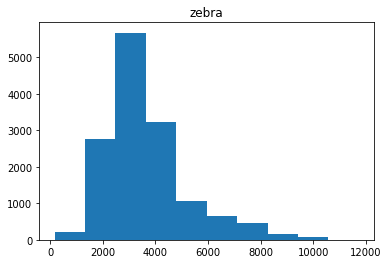

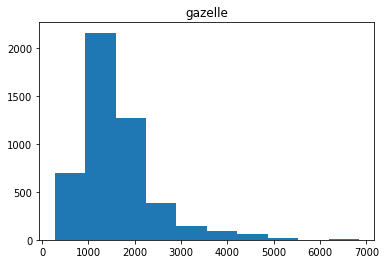

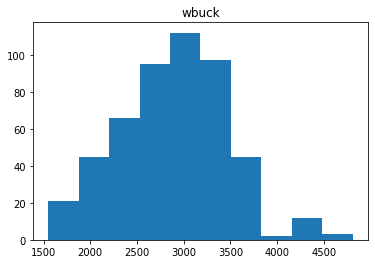

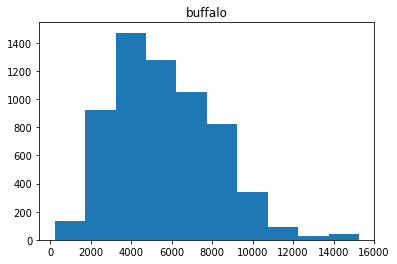

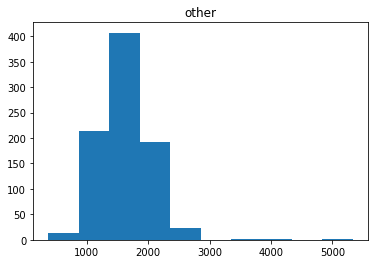

In [27]:
dataset_dicts = train_dicts
class_names = train_metadata.get("thing_classes")

object_sizes = {c_ind: [] for c_ind, c in enumerate(class_names)}

for entry in dataset_dicts:
    annotations = entry["annotations"]
    for annotation in annotations:
        if annotation.get("iscrowd", 0):
            continue
            
        obj_class = annotation['category_id']
        bbox = annotation['bbox']
        bbox_area = bbox[2] * bbox[3]
        object_sizes[obj_class].append(bbox_area)

for obj_name, sizes in zip(class_names, object_sizes.values()):
    sizes = np.array(sizes)
    plt.figure()
    plt.hist(sizes)
    plt.title(obj_name)
    print(f"{obj_name}: mean: {np.mean(sizes)}", 
          f"lowwer_quartile: {np.percentile(sizes, 25)}",
          f"upper_quartile: {np.percentile(sizes, 75)}",
          f"num annotations: {len(sizes)}")